<a href="https://colab.research.google.com/github/nvhieu0163/ComparativeOpinionMining_KLTN2023/blob/main/1_CSI_using_BiLSTM_RNN_GRU_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install py_vncorenlp
!pip install transformers
!pip install tokenizers

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.7 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4306 sha256=ce0d070af286ef5b058b3a57a2cb957a2c829fbe6e524d38f53cb489cf238d9f
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import json
import sys

In [ ]:
import py_vncorenlp
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/drive/MyDrive/NCKH_KLTN/Thuc_nghiem/vn_corenlp_2')

In [ ]:
cd "/content/drive/MyDrive/NCKH_KLTN/Vietnamese Car Reviews Dataset/Unlabeled_Data/CSI_phase/Final"

/content/drive/MyDrive/NCKH_KLTN/Vietnamese Car Reviews Dataset/Unlabeled_Data/CSI_phase/Final


In [ ]:
df125 = pd.read_csv("file125_last_update.csv")
df34 = pd.read_csv("file34_last_update.csv")

## Nhị phân

In [ ]:
df_total =  pd.concat([df125, df34], ignore_index =  True)

# 2 labels
df_total.loc[df_total["CSI"] == 2, "CSI"] = 1   # Comparative sentence là 1, non-comparative sentence là 0
df_total.loc[df_total["CSI"] == 3, "CSI"] = 1
df_total.loc[df_total["CSI"] == 4, "CSI"] = 1

<Axes: >

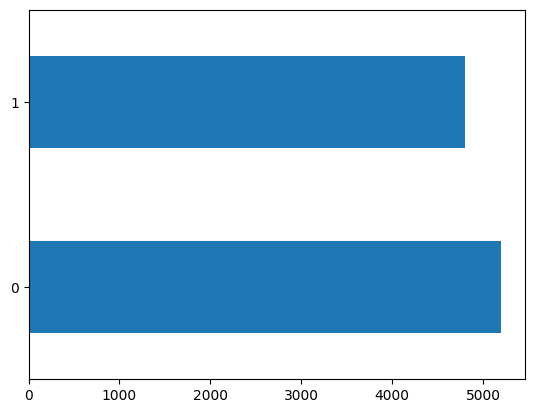

In [ ]:
df_total["CSI"].value_counts().plot.barh()

In [ ]:
token_main = []
for stc in df_total["main"]:
    a = rdrsegmenter.word_segment(stc)
    assert len(a) == 1, 'Độ dài câu văn khác 1'
    token_main.append(a[0])
df_total["main_token"] = token_main

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_total.main_token, df_total.CSI, test_size=0.2, random_state=42)

### Using BiLSTM + RNN

Data preprocessing

In [ ]:
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
VOCAB_SIZE = 6000
max_length = 160
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [ ]:
train_sequences =  tokenizer.texts_to_sequences(X_train)
test_sequences =  tokenizer.texts_to_sequences(X_test)
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, truncating="post", padding="post")
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, truncating="post", padding="post")

In [ ]:
padded_train_sequences.shape

(8000, 160)

In [ ]:
data_vocab_size = len(tokenizer.word_index) + 1
print(data_vocab_size)

4091


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Build model

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Bidirectional, LSTM, Input, GlobalAveragePooling1D, RNN, GlobalAveragePooling2D, Softmax, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa

In [ ]:
# from keras.src import backend

In [ ]:
EPOCHS = 10
# INIT_LR = 1e-4
# MAX_LR = 1e-2

In [ ]:
input_dim = data_vocab_size
embedding_dim = 4096
dropout_threshold = 0.3

In [ ]:
model = Sequential()

# Add embedding layer, input_length = max_length
model.add(Embedding(input_dim = input_dim, output_dim = embedding_dim))
# Add BiLSTM
model.add(Bidirectional(LSTM(units=512, dropout = dropout_threshold, return_sequences=False)))

# model.add(SimpleRNN(2048))
# model.add(Flatten())
# model.add(Dropout(0.3))
# model.add(Dense(2048, activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

adam = Adam(learning_rate = 0.001)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4096)        16756736  
                                                                 
 bidirectional (Bidirection  (None, 1024)              18878464  
 al)                                                             
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [ ]:
metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=2, average='macro')]
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics = metrics)


In [ ]:
model.fit(padded_train_sequences, y_train, epochs = EPOCHS)

Epoch 1/10
250/250 [==============================] - 76s 237ms/step - loss: 0.4826 - categorical_accuracy: 0.7807 - f1_score: 0.7802
Epoch 2/10
250/250 [==============================] - 55s 220ms/step - loss: 0.3332 - categorical_accuracy: 0.8691 - f1_score: 0.8689
Epoch 3/10
250/250 [==============================] - 52s 209ms/step - loss: 0.2436 - categorical_accuracy: 0.9021 - f1_score: 0.9020
Epoch 4/10
250/250 [==============================] - 53s 211ms/step - loss: 0.1843 - categorical_accuracy: 0.9275 - f1_score: 0.9274
Epoch 5/10
250/250 [==============================] - 52s 208ms/step - loss: 0.1378 - categorical_accuracy: 0.9470 - f1_score: 0.9469
Epoch 6/10
250/250 [==============================] - 53s 211ms/step - loss: 0.1051 - categorical_accuracy: 0.9594 - f1_score: 0.9593
Epoch 7/10
250/250 [==============================] - 52s 209ms/step - loss: 0.0697 - categorical_accuracy: 0.9746 - f1_score: 0.9746
Epoch 8/10
250/250 [==============================] - 52s 209m

In [ ]:
model.evaluate(padded_test_sequences, y_test)
preds = model.predict(padded_test_sequences)
p = tf.math.argmax(preds, 1).numpy()
y = tf.math.argmax(y_test, 1).numpy()
print(classification_report(y, p, digits=4))

63/63 [==============================] - 6s 68ms/step
              precision    recall  f1-score   support

           0     0.8607    0.8732    0.8669      1033
           1     0.8624    0.8490    0.8557       967

    accuracy                         0.8615      2000
   macro avg     0.8615    0.8611    0.8613      2000
weighted avg     0.8615    0.8615    0.8615      2000



In [ ]:
from keras.src import backend
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = backend.dot(inputs, self.kernel)
        output = h + backend.dot(prev_output, self.recurrent_kernel)
        return output, [output]

cell = MinimalRNNCell(512)

In [ ]:
GRU_model = Sequential()

# Add embedding layer, input_length = max_length
GRU_model.add(Embedding(input_dim = input_dim, output_dim = embedding_dim))
# Add BiLSTM
GRU_model.add(Bidirectional(GRU(units=512, dropout = dropout_threshold, return_sequences=False)))

# GRU_model.add(SimpleRNN(2048))
# GRU_model.add(Flatten())
# GRU_model.add(Dropout(0.3))
# GRU_model.add(Dense(2048, activation = 'relu'))
# GRU_model.add(Dropout(0.3))
GRU_model.add(Dense(1024, activation = 'relu'))
GRU_model.add(Dropout(0.2))
GRU_model.add(Dense(512, activation = 'relu'))
GRU_model.add(Dropout(0.2))
GRU_model.add(Dense(64, activation = 'relu'))
GRU_model.add(Dense(2, activation = 'softmax'))

adam = Adam(learning_rate = 0.001)

In [ ]:
GRU_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 4096)        16756736  
                                                                 
 bidirectional_17 (Bidirect  (None, 1024)              14161920  
 ional)                                                          
                                                                 
 dense_71 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_40 (Dropout)        (None, 1024)              0         
                                                                 
 dense_72 (Dense)            (None, 512)               524800    
                                                                 
 dropout_41 (Dropout)        (None, 512)               0         
                                                     

In [ ]:
metrics=[tf.keras.metrics.CategoricalAccuracy(), tfa.metrics.F1Score(num_classes=2, average='macro')]
GRU_model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics = metrics)

In [ ]:
GRU_model.fit(padded_train_sequences, y_train, epochs = EPOCHS)

Epoch 1/10
250/250 [==============================] - 54s 200ms/step - loss: 0.4741 - categorical_accuracy: 0.7835 - f1_score: 0.7828
Epoch 2/10
250/250 [==============================] - 42s 167ms/step - loss: 0.3051 - categorical_accuracy: 0.8754 - f1_score: 0.8752
Epoch 3/10
250/250 [==============================] - 41s 164ms/step - loss: 0.2253 - categorical_accuracy: 0.9128 - f1_score: 0.9127
Epoch 4/10
250/250 [==============================] - 41s 163ms/step - loss: 0.1614 - categorical_accuracy: 0.9373 - f1_score: 0.9372
Epoch 5/10
250/250 [==============================] - 40s 162ms/step - loss: 0.1116 - categorical_accuracy: 0.9590 - f1_score: 0.9589
Epoch 6/10
250/250 [==============================] - 40s 162ms/step - loss: 0.0879 - categorical_accuracy: 0.9676 - f1_score: 0.9676
Epoch 7/10
250/250 [==============================] - 40s 161ms/step - loss: 0.0620 - categorical_accuracy: 0.9781 - f1_score: 0.9781
Epoch 8/10
250/250 [==============================] - 40s 161m

In [ ]:
GRU_model.evaluate(padded_test_sequences, y_test)
preds = GRU_model.predict(padded_test_sequences)
p = tf.math.argmax(preds, 1).numpy()
y = tf.math.argmax(y_test, 1).numpy()
print(classification_report(y, p, digits=4))

63/63 [==============================] - 4s 48ms/step
              precision    recall  f1-score   support

           0     0.8301    0.8984    0.8629      1033
           1     0.8810    0.8035    0.8405       967

    accuracy                         0.8525      2000
   macro avg     0.8555    0.8509    0.8517      2000
weighted avg     0.8547    0.8525    0.8520      2000

